# Overfitting and regularization

In [the last tutorial](./P02-C03-softmax-regression-scratch.ipynb), we introduced the task of multiclass classification. We showed how you can tackle this problem with a linear model called logistic regression. Owing to some amount of randomness, you might get slightly different results, but when I ran the notebook, the model achieved 88.1% accuracy on the training data and actually did slightly (but not significantly) better on the test data than on the training data. 
 
Not every algorithm that performs well on training data will also perform well on test data. Take, for example, a trivial algorithm that memorizes its inputs and stores the associated labels. This model would have 100% accuracy on training data but would have no way of making any prediction at all on previously unseen data. 

The goal of supervised learning is to produce models that *generalize* to previously unseen data. When a model achieves low error on training data but performs much worse on test data, we say that the model has *overfit*. This means that the model has caught on to idiosyncratic features of the training data (e.g. one "2" happened to have a white pixel in top-right corner), but hasn't really picked up on general patterns. 

We can express this more formally. The quantity we really care about is the test error $e$. Because this quantity reflects the error of our model when generalized previously unseen data, we commonly call it the *generalization error*. When we have simple models and abundant data, we expect the generalization error to resemble the training error. When we work with more complex models and fewer examples, we expect the training error to go down but the generalization gap to grow. Fixing the size of the dataset, the following graph should give you some intuition about what we generally expect to see.

![](../img/regularization-overfitting.png)

What precisely constitutes model complexity is a complex matter. Many factors govern whether a model will generalize well. For example a model with more parameters might be considered more complex. A model whose parameters can take a wider range of values might be more complex. Often with neural networks, we think of a model that takes more training steps as more complex, and one subject to *early stopping* as less complex. 

It can be difficult to compare the complexity among members of very different model classes (say decision trees versus neural networks). Researchers in the field of statistical learning theory have developed a large body of mathematical analysis that formulizes the notion of model complexity and provides guarantees on the generalization error for simple classes of models. *We won't get into this theory but may delve deeper in a future chapter*. For now a simple rule of thumb is quite useful: A model that can readily explain *arbitrary* facts is what statisticians view as complex, whereas one that has only a limited expressive power but still manages to explain the data well is probably closer to the truth. In philosophy this is closely related to Popper's criterion of [falsifiability](https://en.wikipedia.org/wiki/Falsifiability) of a scientific theory: a theory is good if it fits data and if there are specific tests which can be used to disprove it. This is important since all statistical estimation is [post hoc](https://en.wikipedia.org/wiki/Post_hoc), i.e. we estimate after we observe the facts, hence vulnerable to the associated fallacy. Ok, enough of philosophy, let's get to more tangible issues.

To give you some intuition in this chapter, we'll focus on a few factors that tend to influence the generalizability of a model class:

1. **The number of tunable parameters.** When the number of tunable parameters, sometimes denoted the number of degrees of freedom, is large, models tend to be more susceptible to overfitting.
2. **The values taken by the parameters.** When weights can take a wider range of values, models can be more susceptible to over fitting.
3. **The number of training examples.** It's trivially easy to overfit a dataset containing only one or two examples even if your model is simple. But overfitting a dataset with millions of examples requires an extremely flexible model.

When classifying handwritten digits before, we didn't overfit because our 60,000 training examples far out numbered the  $784 \times 10 = 7,840$ weights plus $10$ bias terms gave us far fewer parameters than training examples. Let's see how things can go wrong. We begin with our import ritual.

In [1]:
from __future__ import print_function
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
import numpy as np
ctx = mx.cpu()
mx.random.seed(1)


# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


## Load the MNIST dataset

In [2]:
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)), 
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)), 
                               batch_size, shuffle=False)

## Allocate model parameters and define model

We pick a simple linear model $f(x) = W x + b$ with subsequent softmax, i.e. $p(y|x) \propto \exp(f(x)_y)$. This is about as simple as it gets.

In [3]:
W = nd.random_normal(shape=(784,10))
b = nd.random_normal(shape=10)

params = [W, b]

for param in params:
    param.attach_grad()
    
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = nd.softmax(y_linear, axis=1)
    return yhat

## Define loss function and optimizer

A sensible thing to do is to minimize the negative log-likelihood of the data, i.e. $-\log p(y|x)$. Statisticians have proven that this is actually the most *efficient* estimator, i.e. the one that makes the most use of the data provided. This is why it is so popular.

In [4]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

## Write evaluation loop to calculate accuracy

Ultimately we want to recognize digits. This is a bit different from knowing the *probability* of a digit - when given an image we need to *decide* what digit we are seeing, *regardless* of how uncertain we are. Hence we measure the number of actual misclassifications. 

For diagnosis purposes, it is always a good idea to calculate the average loss function.

In [5]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        loss = cross_entropy(output, label_one_hot)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return (numerator / denominator).asscalar(), loss_avg


## Write a utiltiy function to plot the learning curves
Just to visualize how loss functions and accuracy changes over the number of iterations.

In [6]:
def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))
    
    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)
    
    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)
    
    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

## Execute training loop

We now train the model until there is no further improvement. Our approach is actually a bit naive since we will keep the learning rate unchanged but it fits the purpose (we want to keep the code simple and avoid confusing anyone with further tricks for adjusting learning rate schedules). 

Completed epoch 100. Train Loss: 0.566273033619, Test Loss 1.5746627599, Train_acc 0.881, Test_acc 0.689
Completed epoch 200. Train Loss: 0.26965076616, Test Loss 1.38370378688, Train_acc 0.944, Test_acc 0.707
Completed epoch 300. Train Loss: 0.160881942604, Test Loss 1.32558117807, Train_acc 0.973, Test_acc 0.72
Completed epoch 400. Train Loss: 0.0981378054712, Test Loss 1.30310786143, Train_acc 0.986, Test_acc 0.719
Completed epoch 500. Train Loss: 0.0617666669423, Test Loss 1.29307925329, Train_acc 0.991, Test_acc 0.724
Completed epoch 600. Train Loss: 0.0444683423266, Test Loss 1.28308360279, Train_acc 0.999, Test_acc 0.733
Completed epoch 700. Train Loss: 0.0345032936893, Test Loss 1.27337755263, Train_acc 1.0, Test_acc 0.741
Completed epoch 800. Train Loss: 0.0287693049177, Test Loss 1.26571554318, Train_acc 1.0, Test_acc 0.741
Completed epoch 900. Train Loss: 0.0242801742861, Test Loss 1.25991469994, Train_acc 1.0, Test_acc 0.745
Completed epoch 1000. Train Loss: 0.0209092347068

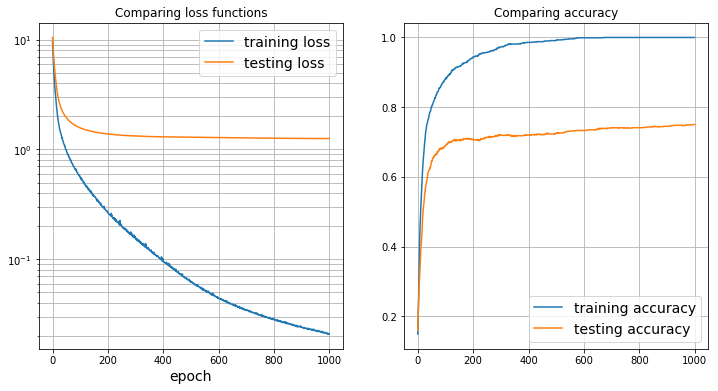

In [7]:
epochs = 1000
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)
            
    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)
    
    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)
    
    
    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" % 
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)


## What Happened?

By the 700th epoch, our model achieves 100% accuracy on the training data. However, it only classifies 75% of the test examples accurately. This is a clear case of overfitting. At a high level, there's reason about what went wrong. Because we have 7450 parameters and only 1000 data points, there are actually many settings of the parameters that could produce 100% accuracy on training data. 

To get some intuition imagine that we wanted to fit a dataset with 2 dimensional data and 2 data points. Our model has three degrees of freedom, and thus for any dataset can find an arbitrary number of separators that will perfectly classify our training points. Note below that we can produce completely orthogonal separators that both classify our training data perfectly. Even if it seems preposterous that they could both describe our training data well.

![](../img/overfitting-low-data.png)




## Regularization

Now that we've characterized the problem of overfitting, we can begin talking about some solutions. 
Broadly speaking the family of techniques geared towards mitigating overfitting are referred to as *regularization*.
The core idea is this: when a model is overfitting, its training error is substantially lower than its test error. We're already doing as well as we possibly can on the training data, but our test data performance leaves something to be desired. Typically, regularization techniques attempt to trade off our training performance in exchange for lowering our test error. 

There are several straight forward techniques we might employ. Given the intuition from the previous chart, we might attempt to make our model less complex. One way to do this would be to lower the number of free parameters. For example, we could throw away some subset of our input features (and thus the corresponding parameters) that we thought were least informative. 

![](../img/regularization-overfitting.png)

Another approach is to limit the values that our weights might take. One common approach is to force the weights to take small values. 
[give more intuition with example of polynomial curve fitting]
We can accomplish this by changing our optimization objective to penalize the value of our weights. 
The most popular regularizer is the $\ell^2_2$ norm. For linear models, $\ell^2_2$ regularization as the additional benefit that it makes the solution unique, even when our model is overparametrized.

$$\sum_{i}(\hat{y}-y)^2 + \lambda \| \textbf{w} \|^2_2$$

Here, $\|\textbf{w}\|$ is the $\ell^2_2$ norm and $\lambda$ is a hyper-parameter that determines how aggressively we want to push the weights towards 0. In code, we can express the $\ell^2_2$ penalty succinctly:

In [8]:
def l2_penalty(params):
    penalty = nd.zeros(shape=1)
    for param in params:
        penalty = penalty + nd.sum(param ** 2)
    return penalty

## Re-initializing the parameters

Just for good measure to ensure that the results in the second training run don't depend on the first one.

In [9]:
for param in params:
    param[:] = nd.random_normal(shape=param.shape)

## Training L2-regularized logistic regression

In [10]:
epochs = 1000
moving_loss = 0.
l2_strength = .1
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = nd.sum(cross_entropy(output, label_one_hot)) + l2_strength * l2_penalty(params)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)
        
            
    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)
    
    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)
    
    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" % 
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))  
        


Completed epoch 100. Train Loss: 0.42777131591, Test Loss 1.22399537638, Train_acc 0.881, Test_acc 0.712
Completed epoch 200. Train Loss: 0.188422976062, Test Loss 0.826848126948, Train_acc 0.954, Test_acc 0.764
Completed epoch 300. Train Loss: 0.139540826436, Test Loss 0.655385751277, Train_acc 0.98, Test_acc 0.793
Completed epoch 400. Train Loss: 0.128715998027, Test Loss 0.573722947389, Train_acc 0.99, Test_acc 0.816
Completed epoch 500. Train Loss: 0.1260728091, Test Loss 0.534426363185, Train_acc 0.993, Test_acc 0.831
Completed epoch 600. Train Loss: 0.127419423312, Test Loss 0.515162894502, Train_acc 0.993, Test_acc 0.841
Completed epoch 700. Train Loss: 0.128798569087, Test Loss 0.507757460698, Train_acc 0.993, Test_acc 0.838
Completed epoch 800. Train Loss: 0.128285415471, Test Loss 0.502912860364, Train_acc 0.991, Test_acc 0.843
Completed epoch 900. Train Loss: 0.127388462424, Test Loss 0.500751012936, Train_acc 0.991, Test_acc 0.842
Completed epoch 1000. Train Loss: 0.1279537

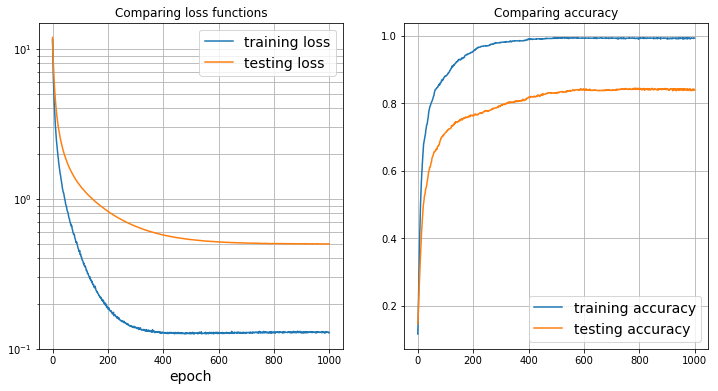

In [11]:
## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

## Analysis

By adding $L_2$ regularization we were able to increase the performance on test data from 75% accuracy to 83% accuracy. That's a 32% reduction in error. In a lot of applications, this big an improvement can make the difference between a viable product and useless system. Note that L2 regularization is just one of many ways of controlling capacity. Basically we assumed that small weight values are good. But there are many more ways to constrain the values of the weights:

* We could require that the total sum of the weights is small. That is what $L_1$ regularization does via the penalty $\sum_i |w_i|$. 
* We could require that the largest weight is not too large. This is what $L_\infty$ regularization does via the penalty $\max_i |w_i|$. 
* We could require that the number of nonzero weights is small, i.e. that the weight vectors are *sparse*. This is what the $L_0$ penalty does, i.e. $\sum_i I\{w_i \neq 0\}$. This penalty is quite difficult to deal with explicitly since it is nonsmooth. There is a lot of research that shows how to solve this problem approximately using an $L_1$ penalty. 

![](../img/regularization.png)

From left to right: $L_2$ regularization, which constrains the parameters to a ball, $L_1$ regularization, which constrains the parameters to a diamond (for lack of a better name, this is often referred to as an $L_1$-ball), and $L_\infty$ regularization, which constrains the parameters to a hypercube. 

All of this raises the question of **why** regularization is any good. After all, choice is good and giving our model more flexibility *ought* to be better (e.g. there are plenty of papers which show improvements on ImageNet using deeper networks). What is happening is somewhat more subtle. Allowing for many different parameter values allows our model to cherry pick a combination that is *just right* for all the training data it sees, without really learning the underlying mechanism. Since our observations are likely noisy, this means that we are trying to approximate the errors at least as much as we're learning what the relation between data and labels actually is. There is an entire field of statistics devoted to this issue - Statistical Learning Theory. For now, a few simple rules of thumb suffice:

* Fewer parameters tend to be better than more parameters.
* Better engineering for a specific problem that takes the actual problem into account will lead to better models, due to the prior knowledge that data scientists have about the problem at hand.
* $L_2$ is easier to optimize for than $L_1$. In particular, many optimizers will not work well out of the box for $L_1$. Using the latter requires something called *proximal operators*.
* Dropout and other methods to make the model robust to perturbations in the data often work better than off-the-shelf $L_2$ regularization.

We conclude with an [XKCD Cartoon](https://xkcd.com/882/) which captures the entire situation more succinctly than the proceeding paragraph. 

![](https://imgs.xkcd.com/comics/significant.png)


## Next
[Overfitting and regularization with gluon](../chapter02_supervised-learning/regularization-gluon.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)